In [107]:
import pandas as pd
import numpy as np
from enum import IntEnum

In [98]:
MODEL_NAME = "vgg19_gtsrb_new_models"
TARGET_LAYER = "classes_block1_conv1"

In [108]:
class Patterns(IntEnum):
    SAME_FEATURE_MAP_SAME_ROW = 0
    SAME_FEATURE_MAP_SAME_COLUMN = 1
    SAME_FEATURE_MAP_BLOCK = 2
    SAME_FEATURE_MAP_RANDOM = 3
    MULTIPLE_FEATURE_MAPS_BULLET_WAKE = 4
    MULTIPLE_FEATURE_MAPS_BLOCK = 5
    MULTIPLE_FEATURE_MAPS_SHATTER_GLASS = 6
    MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS = 7
    MULTIPLE_FEATURE_MAPS_UNCATEGORIZED = 8
    SKIP_4 = 1001
    CHANNEL_ALIGNED_BLOCKS = 1002
    TENSOR_ALIGNED_SINGLE_BLOCK = 1003
    SINGLE_BLOCK = 1004
    MULTI_CHANNEL_MULTI_BLOCK = 1005
    SHATTERED_CHANNEL = 1006
    QUASI_SHATTERED_CHANNEL = 1007
    SINGLE_CHANNEL_ALTERNATED_BLOCKS = 1008

In [111]:
def replacePatternNames(col):
    return col.map(Patterns())

In [99]:
data = pd.read_csv("pattern_" + MODEL_NAME + ".csv")

In [100]:
data

,Unnamed: 0,Mode,Layer_name,Sample_id,Cardinality,Pattern,Misprediction
0,0,FaultInjection,classes_block1_conv1,0,2,4,0
1,1,FaultInjection,classes_block1_conv1,0,32,1001,1
2,2,FaultInjection,classes_block1_conv1,0,196,1005,1
3,3,FaultInjection,classes_block1_conv1,0,16,1001,1
4,4,FaultInjection,classes_block1_conv1,0,16,1001,1
...,...,...,...,...,...,...,...
61435,20475,Ranger_Ranger_Layer,classes_block5_conv4,9,30,1004,0
61436,20476,Ranger_Ranger_Layer,classes_block5_conv4,9,29,1004,1
61437,20477,Ranger_Ranger_Layer,classes_block5_conv4,9,26,1004,1
61438,20478,Ranger_Ranger_Layer,classes_block5_conv4,9,26,1004,1


In [101]:
grouped_data = data.groupby(by=["Layer_name","Mode","Pattern"]).agg({'Misprediction': ['count',np.sum]}).reset_index()
grouped_data

Layer_name                   Mode Pattern Misprediction      
                                                                 count   sum
0    classes_block1_conv1         FaultInjection      -1             3     0
1    classes_block1_conv1         FaultInjection       4            14     7
2    classes_block1_conv1         FaultInjection    1001           246   240
3    classes_block1_conv1         FaultInjection    1004           829   826
4    classes_block1_conv1         FaultInjection    1005           172   172
..                    ...                    ...     ...           ...   ...
278  classes_block5_conv4  Ranger_Clipping_Layer    1004          1256   843
279  classes_block5_conv4    Ranger_Ranger_Layer      -1             8     0
280  classes_block5_conv4    Ranger_Ranger_Layer       4            15     4
281  classes_block5_conv4    Ranger_Ranger_Layer       8             5     5
282  classes_block5_conv4    Ranger_Ranger_Layer    1004          1252  1171

[283 rows x 5 columns]

In [102]:
conv1 = grouped_data.loc[grouped_data['Layer_name'] == "classes_block5_conv4"]
conv1["Fault_damage_level"] = (conv1['Misprediction']['sum'] /conv1['Misprediction']['count']) * 100
conv1["Fault_damage_level"] = conv1["Fault_damage_level"].round(1)
conv1 = conv1.drop(columns=['Misprediction'])
conv1

/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without 

,Layer_name,Mode,Pattern,Fault_damage_level
,,,,
271,classes_block5_conv4,FaultInjection,-1,0.0
272,classes_block5_conv4,FaultInjection,4,77.8
273,classes_block5_conv4,FaultInjection,8,100.0
274,classes_block5_conv4,FaultInjection,1004,94.2
275,classes_block5_conv4,Ranger_Clipping_Layer,-1,16.7
276,classes_block5_conv4,Ranger_Clipping_Layer,4,40.0
277,classes_block5_conv4,Ranger_Clipping_Layer,8,0.0
278,classes_block5_conv4,Ranger_Clipping_Layer,1004,67.1
279,classes_block5_conv4,Ranger_Ranger_Layer,-1,0.0


In [113]:

layer_pattern_report

/home/nicola/miniconda3/envs/nicola/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Pattern                                                         
Mode         FaultInjection Ranger_Clipping_Layer Ranger_Ranger_Layer
0         -1            0.0                  16.7                 0.0
1          4           77.8                  40.0                26.7
2          8          100.0                   0.0               100.0
3       1004           94.2                  67.1                93.5

In [117]:
layer_pattern_report = conv1.pivot(index =['Layer_name','Pattern'], columns =['Mode'])["Fault_damage_level"].reset_index()
layer_pattern_report= layer_pattern_report.drop(columns=['Layer_name'])

layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(-1,"RANDOM")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(0,"SAME_FEATURE_MAP_SAME_ROW")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1,"SAME_FEATURE_MAP_SAME_COLUMN")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(2,"SAME_FEATURE_MAP_BLOCK")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(3,"SAME_FEATURE_MAP_RANDOM")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(4,"MULTIPLE_FEATURE_MAPS_BULLET_WAKE")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(5,"MULTIPLE_FEATURE_MAPS_BLOCK")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(6,"MULTIPLE_FEATURE_MAPS_SHATTER_GLASS")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(7,"MULTIPLE_FEATURE_MAPS_QUASI_SHATTER_GLASS")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(8,"MULTIPLE_FEATURE_MAPS_UNCATEGORIZED")

layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1001,"SKIP_4")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1002,"CHANNEL_ALIGNED_BLOCKS")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1003,"TENSOR_ALIGNED_SINGLE_BLOCK")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1004,"SINGLE_BLOCK")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1005,"MULTI_CHANNEL_MULTI_BLOCK")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1006,"SHATTERED_CHANNEL")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"QUASI_SHATTERED_CHANNEL")
layer_pattern_report['Pattern'] = layer_pattern_report['Pattern'].replace(1007,"SINGLE_CHANNEL_ALTERNATED_BLOCKS")

layer_pattern_report = layer_pattern_report.set_index([ 'Pattern'])


Pattern                 \
Mode                                      FaultInjection   
0                                      -1            0.0   
1                                       4           77.8   
2     MULTIPLE_FEATURE_MAPS_UNCATEGORIZED          100.0   
3                                    1004           94.2   

                                                
Mode Ranger_Clipping_Layer Ranger_Ranger_Layer  
0                     16.7                 0.0  
1                     40.0                26.7  
2                      0.0               100.0  
3                     67.1                93.5

<AxesSubplot:xlabel='Pattern'>

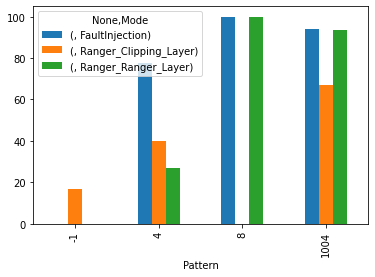

In [104]:
layer_pattern_report.plot.bar()